# Predicting V1 neuronal responses using a CNN with a readout layer  

### Here is a NeuroAI project I worked on a while ago to build a model that can predict the response of simulated V1 neurons to a set of naturalistic color images. Following the example of [this NeurIPS paper](https://proceedings.neurips.cc/paper/2017/hash/8c249675aea6c3cbd91661bbae767ff1-Abstract.html), I implement a similar model that consists of a CNN with a sparse readout layer that can factorize between neurons that code for spatial and feature dimensions. Here this is illustrated on a datasets of simulated V1 responses.

## Data Preparation

In [ ]:
# import necessary packages
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# set a seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [ ]:
# load in the data
# load the simulated V1 neural data
data_orig = np.load('neural_responses.npz', allow_pickle=True, encoding='bytes')
# Check what's in the data
print("List all arrays:", data_orig.files)
print(data_orig)

# Convert all arrays to NumPy arrays
keys = data_orig.files
data = {key: data_orig[key] for key in keys}
#print(data)

# Get to know your data (shape, type, min, max, and mean values, and std)
for key in data.keys():
  print(key, data[key].shape, data[key].dtype, np.min(data[key]), np.max(data[key]), np.mean(data[key]), np.std(data[key]))

#print(data['labels'])

List all arrays: ['x_train', 'y_train', 'x_test', 'y_test', 'positions', 'labels']
NpzFile 'neural_responses.npz' with keys: x_train, y_train, x_test, y_test, positions...
x_train (10000, 32, 32, 3) uint8 0 255 120.67770377604167 64.50581647365674
y_train (10000, 128) float32 -8.606536 10.295854 0.16323206 1.3363256
x_test (1000, 32, 32, 3) uint8 0 255 120.95178678385416 64.30930573966384
y_test (1000, 128) float32 -5.44648 7.209215 0.15295187 0.87009203
positions (128, 2) int64 0 15 7.890625 4.427778744401644
labels (128,) int64 52 58 55.0 3.0


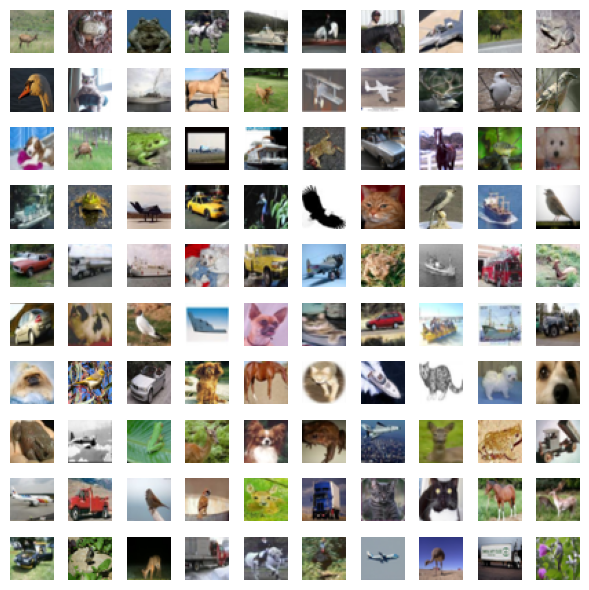

In [ ]:
# Let's visualize some of the image stimuli and see what they look like

import random
import matplotlib.pyplot as plt

# Select some subdata to plot images from
imgs = data['x_train']

# Randomly select a subset of images to plot
num_images = 100
selected_indices = random.sample(range(imgs.shape[0]), num_images)
selected_images = imgs[selected_indices]

# Plot the selected images in a grid (8x5)
num_rows = 10
num_cols = 10

# Plot the selected images
plt.figure(figsize=(6, 6))
for i, img in enumerate(selected_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training, validation, and testing sets
import random
from sklearn.model_selection import train_test_split

# Set a seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the validation ratio
val_ratio = 0.2

# Take the training data
x_data = data['x_train']
y_data = data['y_train']

# Split the training data into a training and validation set
train_indices, val_indices = train_test_split(np.arange(len(x_data)), test_size=val_ratio, random_state=42)

# Save the length of set sizes for ease
num_test = len(data["x_test"])
num_val = len(val_indices)
num_train = len(train_indices)

# Print the sizes of the datasets
print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Test set size: {num_test}')
print(f'Total data size: {num_train + num_val + num_test}')

Training set size: 8000
Validation set size: 2000
Test set size: 1000
Total data size: 11000


In [ ]:
# Since we're going to use PyTorch, let's convert our data into a torch dataset and specify the loaders

import torch
from torch.utils.data import Dataset, DataLoader

# Set a batch size and the number of subprocesses
batch_size = 16
num_workers = 2

class NeuroDataset(Dataset):
    def __init__(self, inputs, responses):
        # Normalize the inputs
        # Make a copy of inputs and convert to float32
        self.inputs = inputs.copy().astype(np.float32)
        # Transpose the inputs to change the order of dimensions to (batch_size, channels, height, width)
        self.inputs = np.transpose(self.inputs, (0, 3, 1, 2))
        # Normalize the inputs by subtracting the mean and dividing by the standard deviation
        self.inputs -= np.mean(self.inputs)
        self.inputs /= np.std(self.inputs)
        self.responses = responses.copy()

    def __getitem__(self, n):
        x = torch.tensor(self.inputs[n].copy())
        y = torch.tensor(self.responses[n].copy())
        return x, y

    def __len__(self):
        return len(self.inputs)

# Verify that train_indices are within a valid range
print("Max train_indices:", np.max(train_indices))
print("Min train_indices:", np.min(train_indices))

# Check shapes of the data
print("Shape of x_data[train_indices]:", x_data[train_indices].shape)
print("Shape of y_data[train_indices]:", y_data[train_indices].shape)

# Create the datasets
trainset = NeuroDataset(x_data[train_indices], y_data[train_indices])
valset = NeuroDataset(x_data[val_indices], y_data[val_indices])
testset = NeuroDataset(data['x_test'], data['y_test'])

# Create the dataloaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Max train_indices: 9999
Min train_indices: 1
Shape of x_data[train_indices]: (8000, 32, 32, 3)
Shape of y_data[train_indices]: (8000, 128)


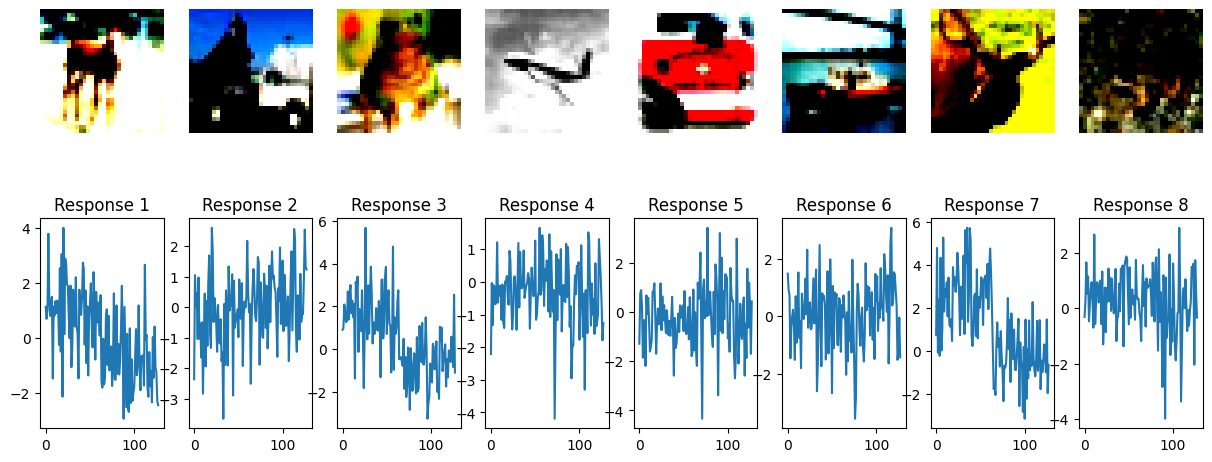

In [ ]:
# Plot an example batch of the images and the target latents

# Function to plot an example batch
def plot_example_batch(loader):
    dataiter = iter(loader)
    images, latents = next(dataiter)

    # Take only half of the batch for better visibility
    half_batch_size = len(images) // 2
    images = images[:half_batch_size]
    latents = latents[:half_batch_size]

    # Denormalize images for plotting
    images = images.numpy()
    images = (images * np.std(images)) + np.mean(images)
    images = np.clip(images, 0, 1)
    # Change shape to (batch_size, height, width, channels)
    images = images.transpose(0, 2, 3, 1)

    # Plot the images and corresponding responses
    fig, axes = plt.subplots(2, len(images), figsize=(15, 6))
    for i in range(len(images)):
        ax_img = axes[0, i]
        ax_lbl = axes[1, i]

        # Plot image
        ax_img.imshow(images[i])
        ax_img.axis('off')

        # Plot response
        ax_lbl.plot(latents[i].numpy())
        ax_lbl.set_title(f"Response {i+1}")

    plt.show()

# Plot an example batch from the trainloader
plot_example_batch(trainloader)

## Data Investigation

Let's have a closer look at our data. What does the frequency spectrum of the response distributions look like? What can a PCA tell us?

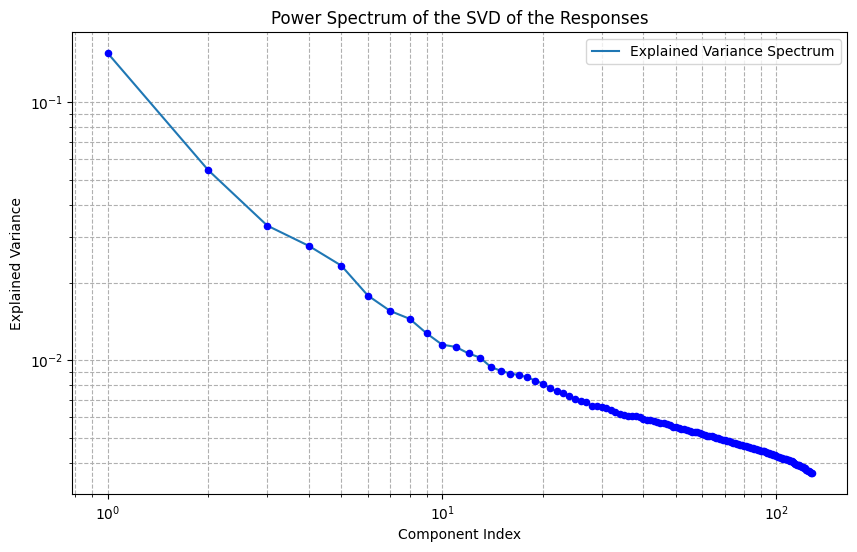

In [ ]:
# Look at the SVD (PCA) of data: What's the spectrum of the response distribution like?

# Define the responses
responses = trainset.responses

# Perform SVD on the response data
# u = matrix of left singular vectors
# s = diagonal matrix of singular values
# v = matrix of right singular vectors
u, s, v = np.linalg.svd(responses, full_matrices=False)

# Compute the explained variance of each singular value
var_exp = s ** 2 / np.sum(s ** 2)

# Plot the power spectrum (via explained variance) of the SVD on a log-log scale
plt.figure(figsize=(10, 6))
components = np.arange(1, len(var_exp) + 1)
plt.loglog(np.arange(1, len(var_exp) + 1), var_exp, label='Explained Variance Spectrum')
plt.xlabel('Component Index')
plt.ylabel('Explained Variance')
plt.title('Power Spectrum of the SVD of the Responses')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.scatter(components, var_exp, color='b', s=20, zorder=5)
plt.show()

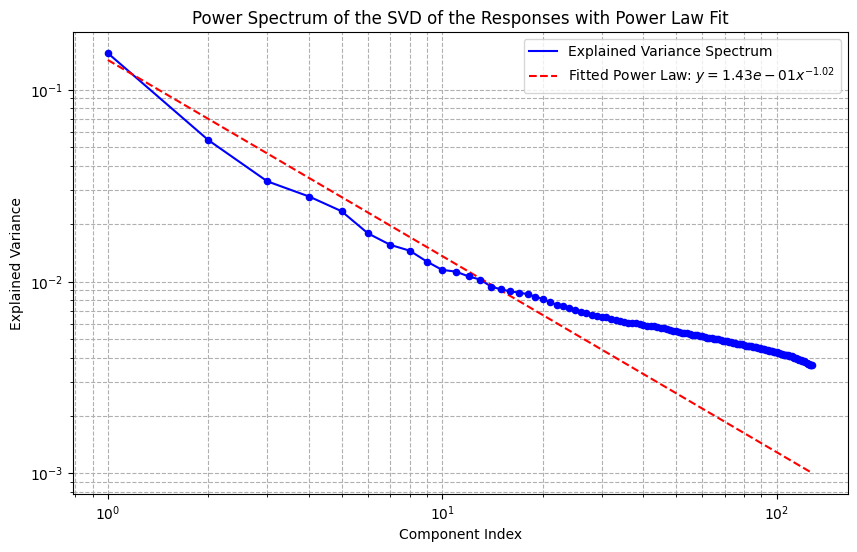

Fitted power law parameters: a = 1.43e-01, k = -1.02


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Fit a power law distribution to the explained variance spectrum
# Define the power law function
def power_law(x, a, k):
    return a * np.power(x, k)

# Prepare the data
components = np.arange(1, len(var_exp) + 1)
y_data = var_exp

# Fit the power law to the data
popt, pcov = curve_fit(power_law, components, y_data)

# Extract the fitted parameters
a, k = popt

# Compute the fitted power law values
fitted_y = power_law(components, a, k)

# Plot the original data and the fitted power law
plt.figure(figsize=(10, 6))
plt.loglog(components, y_data, 'b', label='Explained Variance Spectrum')
plt.loglog(components, fitted_y, 'r--', label=f'Fitted Power Law: $y = {a:.2e} x^{{{k:.2f}}}$')
plt.xlabel('Component Index')
plt.ylabel('Explained Variance')
plt.title('Power Spectrum of the SVD of the Responses with Power Law Fit')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.scatter(components, y_data, color='b', s=20, zorder=5)
plt.show()

# Print the fitted power law parameters
print(f'Fitted power law parameters: a = {a:.2e}, k = {k:.2f}')




### What does the frequency spectrum show us? 

Do we have the same power law in the activation spectrum as [Stringer et al. (2019)] (https://pubmed.ncbi.nlm.nih.gov/31243367/) observe in brains?

Yes, we do! Given a power law y = Ax^k, Stringer and colleagues find that the nth principal component variance scales as 1/n, meaning that the exponent k is -1. Similarly, the exponent of the fitted power law to our data here is k = -1.02. According to their findings, the slow decay of 1/n also implies high-dimensionality of the dataset.

Let's see whether visualizing the principal components can give us more information about what's happening internally.


Explained variance ratio: [0.11970586 0.0396549  0.0310129  0.02610744 0.01981363 0.01775897
 0.0161249  0.01426863 0.01266828 0.01240424 0.01170585 0.01119898
 0.01025254 0.00985079 0.00959706]


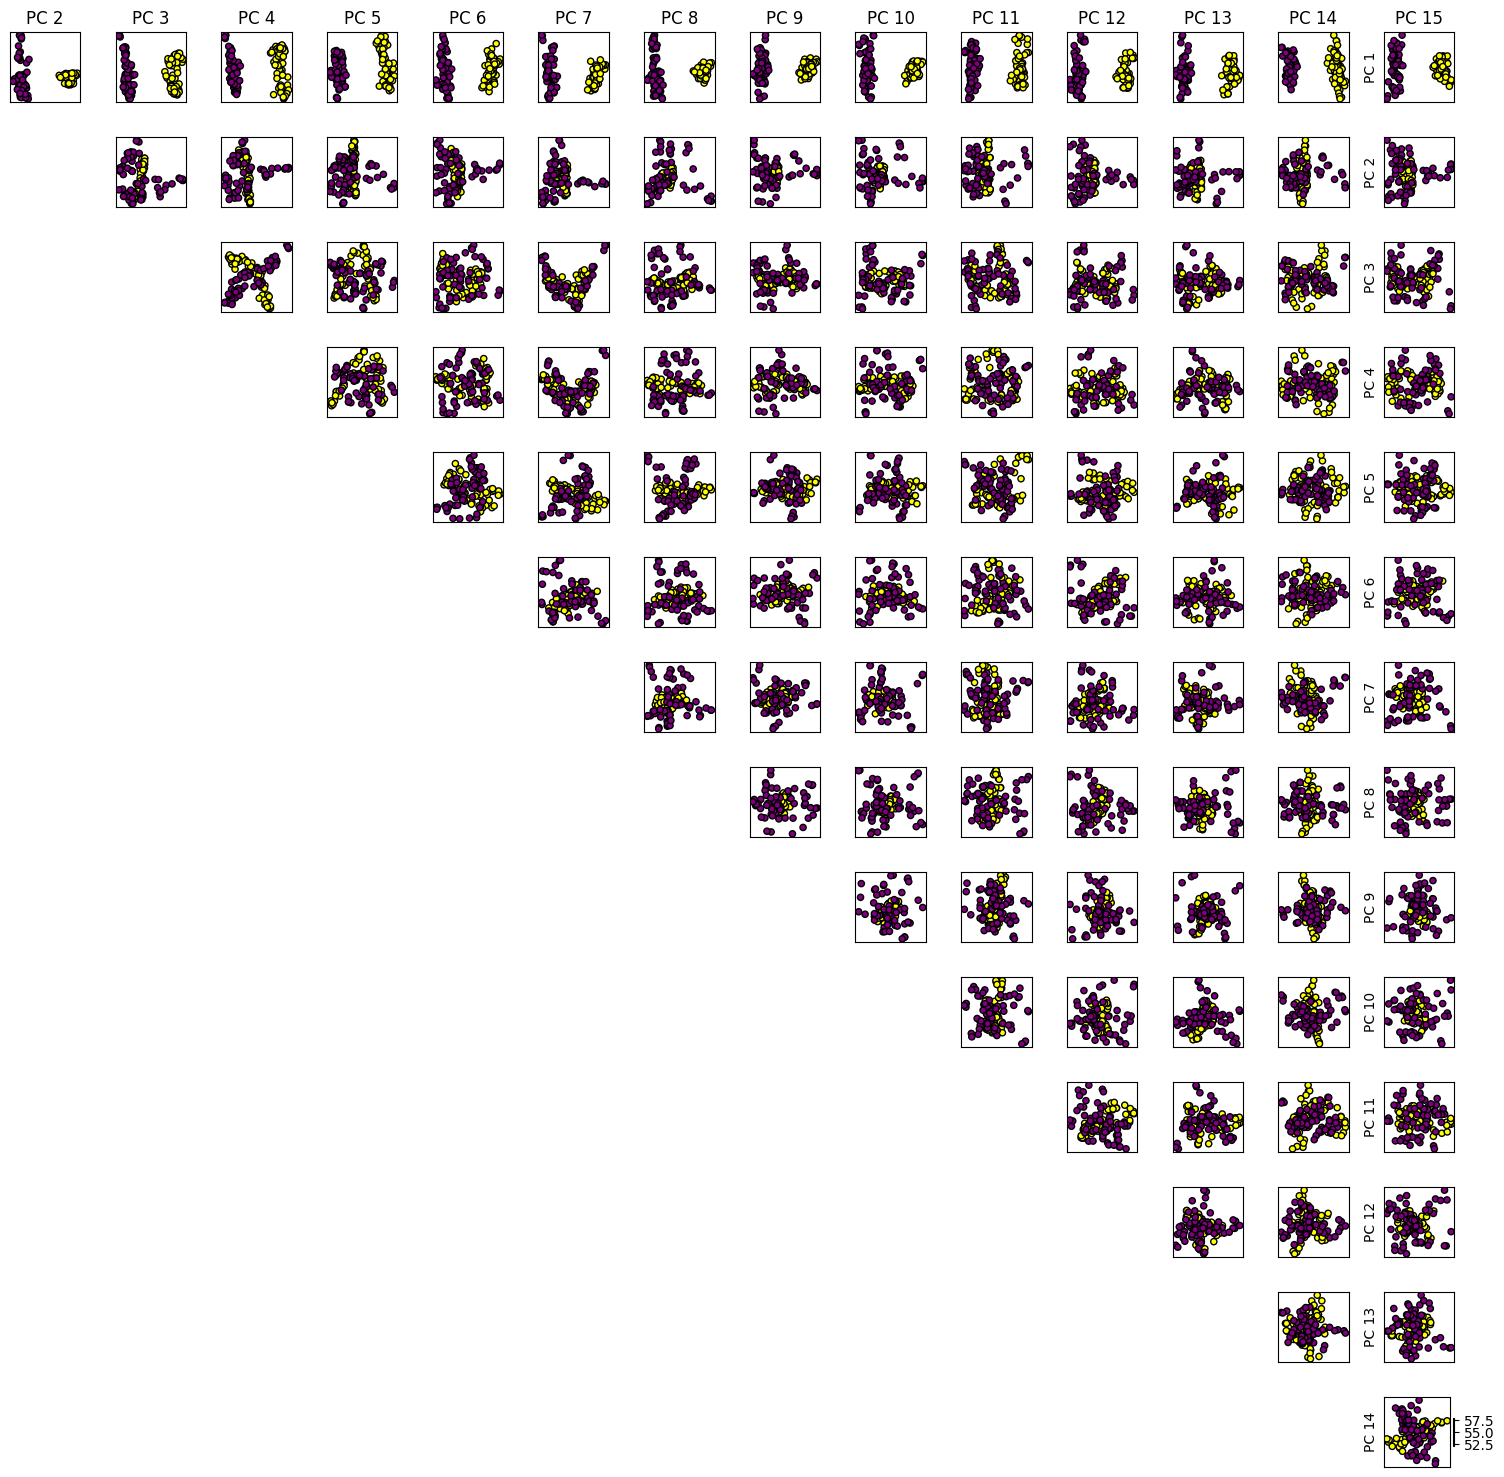

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Transpose the response matrix to have the right dimensions
responses_transposed = responses.T

# Compute PCs of the response data matrix using 2 components for visualization
pca = PCA(n_components=15)
principal_components = pca.fit_transform(responses_transposed)

# Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_ratio}')

# Take the positions and labels data
positions = data['positions']
labels = data['labels']


## Plot the first 15 PCs
# Create a colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('YellowPurple', ['yellow', 'purple'])

plt.figure(figsize=(20, 20))

for i in range(15):
    for j in range(i+1, 15):
        plt.subplot(15, 15, i * 15 + j + 1)
        scatter = plt.scatter(principal_components[:, i], principal_components[:, j], c=labels, cmap=cmap, edgecolor='k', s=20)
        if i == 0:
            plt.title(f'PC {j+1}')
        if j == 14:
            plt.ylabel(f'PC {i+1}')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.colorbar(scatter, ax=plt.gca(), fraction=0.02, pad=0.04)
plt.show()

### So what can the PCA tell us?

It looks like the variance captured in the first few components shows a strong relation to distinguishing between position and label (aka cell type).



## Building the Models

Our main goal is to build a model that uses a CNN with a custom readout layer that computes a weighted sum of input features to differentiate between ‘space’ and ‘feature’ dimensions. Additionally, let's also build two comparison models: a simple linear model and a classic CNN model. During the training of each model, we'll also performe a grid search to determine the optimal regularization weights and implement the Adam optimizer to penalize the mean-squared error.

In [ ]:
# Build a linear model

import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Build a regular CNN model

class SimpleCNN(nn.Module):
    def __init__(self, num_type, output_dim):
        super(SimpleCNN, self).__init__()
        self.core = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=3),  # Output: 32x32x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=3),  # Output: 32x32x64
            nn.ReLU(),
            nn.Conv2d(64, num_type, kernel_size=(5, 5), stride=(1, 1), padding=2),  # Output: 32x32x2
            nn.Flatten()  # Flatten the output
        )
        self.fc = nn.Linear(num_type * 32 * 32, output_dim)  # Adjust the input size if different

    def forward(self, x):
        x = self.core(x)
        x = self.fc(x)
        return x

In [ ]:
# Building the CNN + factorized readout layer model

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# Define a custom readout layer that computes a weighted sum of input features after applying a Gaussian kernel
# size = spatial size of the (square) input; num_in = #input channels (features)
class Readout(nn.Module):
    def __init__(self, num_neuron, size, num_in):
        super().__init__()
        space = torch.linspace(-1, 1, size)
        space = torch.meshgrid(space, space, indexing='ij')
        space = torch.stack(space, 2)
        self.space = nn.Parameter(data=space, requires_grad=False)
        self.centers = nn.Parameter(
            data=torch.zeros(num_neuron, 2), requires_grad=True
        )
        self.log_widths = nn.Parameter(
            data=torch.zeros(num_neuron), requires_grad=True
        )
        self.weights = nn.Parameter(
            data=torch.randn(num_neuron, num_in), requires_grad=True
        )
    # Compute a Gaussian kernel
    def get_kernel(self):
        centers = torch.tanh(self.centers)
        kernel = self.space[:, :, None, :] - centers[None, None, :, :]
        kernel = kernel ** 2
        kernel = torch.sum(kernel, 3)
        widths = torch.exp(self.log_widths)
        kernel = torch.exp(- kernel / widths)
        kernel = kernel / torch.sum(kernel, dim=(0, 1), keepdim=True)
        return kernel

    # Apply the Gaussian kernel to the two input feature maps to computes a weighted sum
    def forward(self, x):
        # x: N x C x H x W
        kernel = self.get_kernel()  # kernel: H x W x K
        out = x[:, :, :, :, None] * kernel[None, None, :, :, :]
        out = torch.sum(out, dim=(2, 3))  # N x C x K
        out = torch.sum(out[:, :, :] * self.weights.T[None], dim=1)
        return out

# Define a model that combines a CNN with the custom readout layer
# The CNN part builds build a feature space based on convolutional layers that match K kernels along the image
# The readout layer computes for each neuron a weighted sum over the entire feature space
class CombinedModel(nn.Module):
    #def __init__(self, num_neuron, num_type, hidden_dim):
    def __init__(self, num_neuron, num_type):
        super(CombinedModel, self).__init__()
        self.core = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=3),
            nn.ReLU(),
            nn.Conv2d(64, num_type, kernel_size=(5, 5), stride=(1, 1), padding=2),
        )

        # Add the readout layer
        self.readout = Readout(
            num_neuron=num_neuron, size=32, num_in=num_type
        )

    def forward(self, x):
        # h is (N, num_type, H, W)
        h = self.core(x)
        return self.readout(h)


In [ ]:
# Add some functions to calculate additional performance metrics

# Calculate the average test loss
def calculate_test_loss(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(dataloader)

# Calculate the Pearson correlation between the model's outputs and the target values
def calculate_correlation(outputs, targets):
    outputs_np = outputs.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()
    corr = np.corrcoef(outputs_np.flatten(), targets_np.flatten())[0, 1]
    return corr


In [ ]:
# Train all of the models

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Mixed precision training to improve performance on GPUs
scaler = GradScaler()

# Needs to match target dim (check this)
num_neurons = 128
# Number of feature types from CNN
num_types = 2
# Number of epochs
num_epochs = 100

Using device: cuda


In [ ]:
# Train the linear model

# Define the input dimensions
input_dim = 32 * 32 * 3
output_dim = 128

# Grid search for optimal regularization weights
regularization_weights = [0.0, 0.001, 0.01, 0.1, 1.0]
best_weight = None
best_val_loss = float('inf')
best_model_state = None

for reg_weight in regularization_weights:
    print(f"\nTraining with regularization weight: {reg_weight}")

    model_linear = LinearModel(input_dim=input_dim, output_dim=output_dim).to('cuda')
    optimizer = optim.Adam(model_linear.parameters(), lr=0.001, weight_decay=reg_weight)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model_linear.train()
        running_loss = 0.0
        running_corr = 0.0
        num_batches = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to('cuda'), targets.to('cuda')

            optimizer.zero_grad()
            outputs = model_linear(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corr += calculate_correlation(outputs, targets).item()
            num_batches += 1

        avg_train_loss = running_loss / num_batches
        avg_train_corr = running_corr / num_batches
        current_lr = optimizer.param_groups[0]['lr']

        if (epoch + 1) % 5 == 0:
            progress = (epoch + 1) / num_epochs * 100
            print(f'Progress: {progress:.2f}% | epoch={epoch+1}/{num_epochs}, Learning Rate: {current_lr:.6f}, Loss: {avg_train_loss:.4f}, Correlation: {avg_train_corr:.4f}')

    # Validation
    model_linear.eval()
    val_loss = 0.0
    total_correlation = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in valloader:
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = model_linear(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            corr = calculate_correlation(outputs, targets)
            total_correlation += corr.item() * inputs.size(0)
            num_batches += 1

    val_loss /= len(valloader.dataset)
    avg_correlation = total_correlation / len(valloader.dataset)

    print(f'Validation Loss: {val_loss:.4f}, Correlation: {avg_correlation:.4f}')

    # Adjust the learning rate based on the validation loss
    scheduler.step(val_loss)

    # Track the best regularization weight and save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weight = reg_weight
        best_model_state = model_linear.state_dict()

print(f"\nBest Regularization Weight: {best_weight}, Validation Loss: {best_val_loss:.4f}")

# Save the best model
if best_model_state is not None:
    ckpt_path_linear = 'Linear_model_best.pth'
    torch.save(best_model_state, ckpt_path_linear)
    print(f"Best model saved to {ckpt_path_linear}")


Training with regularization weight: 0.0
Progress: 5.00% | epoch=5/100, Learning Rate: 0.001000, Loss: 1.2992, Correlation: 0.5668
Progress: 10.00% | epoch=10/100, Learning Rate: 0.001000, Loss: 1.2602, Correlation: 0.5836
Progress: 15.00% | epoch=15/100, Learning Rate: 0.001000, Loss: 1.2429, Correlation: 0.5916
Progress: 20.00% | epoch=20/100, Learning Rate: 0.001000, Loss: 1.2278, Correlation: 0.5975
Progress: 25.00% | epoch=25/100, Learning Rate: 0.001000, Loss: 1.2210, Correlation: 0.6013
Progress: 30.00% | epoch=30/100, Learning Rate: 0.001000, Loss: 1.2084, Correlation: 0.6053
Progress: 35.00% | epoch=35/100, Learning Rate: 0.001000, Loss: 1.1967, Correlation: 0.6092
Progress: 40.00% | epoch=40/100, Learning Rate: 0.001000, Loss: 1.1966, Correlation: 0.6110
Progress: 45.00% | epoch=45/100, Learning Rate: 0.001000, Loss: 1.1755, Correlation: 0.6170
Progress: 50.00% | epoch=50/100, Learning Rate: 0.001000, Loss: 1.1905, Correlation: 0.6143
Progress: 55.00% | epoch=55/100, Learnin

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Progress: 5.00% | epoch=5/100, Learning Rate: 0.001000, Loss: 1.3070, Correlation: 0.5617
Progress: 10.00% | epoch=10/100, Learning Rate: 0.001000, Loss: 1.2858, Correlation: 0.5706
Progress: 15.00% | epoch=15/100, Learning Rate: 0.001000, Loss: 1.2763, Correlation: 0.5734
Progress: 20.00% | epoch=20/100, Learning Rate: 0.001000, Loss: 1.2644, Correlation: 0.5781
Progress: 25.00% | epoch=25/100, Learning Rate: 0.001000, Loss: 1.2660, Correlation: 0.5776
Progress: 30.00% | epoch=30/100, Learning Rate: 0.001000, Loss: 1.2717, Correlation: 0.5765
Progress: 35.00% | epoch=35/100, Learning Rate: 0.001000, Loss: 1.2726, Correlation: 0.5765
Progress: 40.00% | epoch=40/100, Learning Rate: 0.001000, Loss: 1.2644, Correlation: 0.5785
Progress: 45.00% | epoch=45/100, Learning Rate: 0.001000, Loss: 1.2610, Correlation: 0.5789
Progress: 50.00% | epoch=50/100, Learning Rate: 0.001000, Loss: 1.2683, Correlation: 0.5778
Progress: 55.00% | epoch=55/100, Learning Rate: 0.001000, Loss: 1.2673, Correlatio

In [ ]:
# Train the CNN model

# Define the model to use
num_neurons = 128
# Number of output channels from CNN
num_types = 2
output_dim = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(num_type=num_types, output_dim=output_dim).to(device)

# Set loss function to MSE
criterion = nn.MSELoss()
# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00033)
# Decrease LR by a factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Grid search for optimal regularization weights
best_val_loss = float('inf')
best_model_state = None
patience = 300
early_stopping_counter = 0
lr_reduction_counter = 0
max_lr_reductions = 2
regularization_weights = [0.01, 0.1, 1.0, 0.001]

# Lists to store metrics
train_losses = []
val_losses = []
correlations = []
# pos_losses = []

# Training loop
for lambda_w in regularization_weights:
    print(f"Training with λ_w={lambda_w}")
    model = SimpleCNN(num_type=num_types, output_dim=output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00033, weight_decay=lambda_w)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Calculate validation metrics
        val_loss = calculate_test_loss(model, valloader, criterion, device)
        model.eval()
        with torch.no_grad():
            all_outputs = []
            all_targets = []
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                all_outputs.append(outputs)
                all_targets.append(targets)
            all_outputs = torch.cat(all_outputs)
            all_targets = torch.cat(all_targets)
            correlation = calculate_correlation(all_outputs, all_targets)
            # pos_loss = calculate_position_loss(all_outputs, all_targets)

        scheduler.step()

        # Store metrics
        train_losses.append(running_loss / len(trainloader))
        val_losses.append(val_loss)
        correlations.append(correlation)
        # pos_losses.append(pos_loss)

        # Early stopping and learning rate adjustment
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            if lr_reduction_counter < max_lr_reductions:
                print(f"Reducing learning rate, reloading best model state.")
                model.load_state_dict(best_model_state)
                for g in optimizer.param_groups:
                    g['lr'] /= 10
                early_stopping_counter = 0
                lr_reduction_counter += 1
            else:
                print(f"Stopping early after {lr_reduction_counter} learning rate reductions.")
                break

        if (epoch + 1) % 5 == 0:
            progress = (epoch + 1) / num_epochs * 100
            #print(f"Progress: {progress:.2f}% | epoch={epoch+1} lr={scheduler.get_last_lr()[0]:.6e} train_loss={running_loss/len(trainloader):.4e} val_loss={val_loss:.4e} corr={correlation:.4e} pos_loss={pos_loss:.4e}")
            print(f"Progress: {progress:.2f}% | epoch={epoch+1} lr={scheduler.get_last_lr()[0]:.6e} train_loss={running_loss/len(trainloader):.4e} val_loss={val_loss:.4e} corr={correlation:.4e}")

print("Training completed.")

# Save the best model
ckpt_path = 'CNN_model.pth'
torch.save(best_model_state, ckpt_path)
print(f"Best CNN model saved to {ckpt_path}")

# Print final metrics
print("\nFinal metrics after training:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Correlation: {correlations[-1]:.4f}")


# Save the model
#ckpt_path_CNN = 'model_CNN.pth'
#torch.save(model_CNN.state_dict(), ckpt_path_CNN)
#print(f"Model saved to {ckpt_path_CNN}")

Training with λ_w=0.01
Progress: 5.00% | epoch=5 lr=3.219488e-04 train_loss=1.0655e+00 val_loss=1.0760e+00 corr=6.3194e-01
Progress: 10.00% | epoch=10 lr=2.985833e-04 train_loss=1.0536e+00 val_loss=1.0736e+00 corr=6.3313e-01
Progress: 15.00% | epoch=15 lr=2.621907e-04 train_loss=1.0434e+00 val_loss=1.0689e+00 corr=6.3488e-01
Progress: 20.00% | epoch=20 lr=2.163333e-04 train_loss=1.0314e+00 val_loss=1.0612e+00 corr=6.3824e-01
Progress: 25.00% | epoch=25 lr=1.655000e-04 train_loss=1.0176e+00 val_loss=1.0567e+00 corr=6.4029e-01
Progress: 30.00% | epoch=30 lr=1.146667e-04 train_loss=1.0011e+00 val_loss=1.0552e+00 corr=6.4085e-01
Progress: 35.00% | epoch=35 lr=6.880933e-05 train_loss=9.8240e-01 val_loss=1.0512e+00 corr=6.4301e-01
Progress: 40.00% | epoch=40 lr=3.241670e-05 train_loss=9.6359e-01 val_loss=1.0534e+00 corr=6.4261e-01
Progress: 45.00% | epoch=45 lr=9.051203e-06 train_loss=9.4846e-01 val_loss=1.0543e+00 corr=6.4216e-01
Progress: 50.00% | epoch=50 lr=1.000000e-06 train_loss=9.4103

In [ ]:
# Train the combined model: CNN + Readout

# Define the model to use
model = CombinedModel(num_neuron=num_neurons, num_type=num_types).to(device)

# Set loss function to MSE
criterion = nn.MSELoss()
# Use Adam optimizer
optimizer = optim.Adam(model_linear.parameters(), lr=0.00033)
# Decrease LR by a factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Grid search for optimal regularization weights
best_val_loss = float('inf')
best_model_state_combo = None
patience = 300
early_stopping_counter = 0
lr_reduction_counter = 0
max_lr_reductions = 2
regularization_weights = [(0.01, 0.01), (0.1, 0.1), (1.0, 1.0), (0.001, 0.001)]

# Lists to store metrics
train_losses = []
val_losses = []
correlations = []
pos_losses = []


# Training loop
for lambda_m, lambda_w in regularization_weights:
    print(f"Training with λ_m={lambda_m}, λ_w={lambda_w}")
    model = CombinedModel(num_neuron=num_neurons, num_type=num_types).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00033)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                # Add regularization terms
                loss += lambda_m * torch.sum(model.readout.centers ** 2)
                loss += lambda_w * torch.sum(model.readout.weights ** 2)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        # Calculate validation metrics
        val_loss = calculate_test_loss(model, valloader, criterion, device)
        model.eval()
        with torch.no_grad():
            all_outputs = []
            all_targets = []
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                all_outputs.append(outputs)
                all_targets.append(targets)
            all_outputs = torch.cat(all_outputs)
            all_targets = torch.cat(all_targets)
            correlation = calculate_correlation(all_outputs, all_targets)
            #pos_loss = calculate_position_loss(all_outputs, all_targets)

        scheduler.step()

        # Store metrics
        train_losses.append(running_loss / len(trainloader))
        val_losses.append(val_loss)
        correlations.append(correlation)
        #pos_losses.append(pos_loss)

        # Early stopping and learning rate adjustment
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_combo = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            if lr_reduction_counter < max_lr_reductions:
                print(f"Reducing learning rate, reloading best model state.")
                model.load_state_dict(best_model_state_combo)
                for g in optimizer.param_groups:
                    g['lr'] /= 10
                early_stopping_counter = 0
                lr_reduction_counter += 1
            else:
                print(f"Stopping early after {lr_reduction_counter} learning rate reductions.")
                break

        if (epoch + 1) % 5 == 0:
            progress = (epoch + 1) / num_epochs * 100
            #print(f"Progress: {progress:.2f}% | epoch={epoch+1} lr={scheduler.get_last_lr()[0]:.6e} train_loss={running_loss/len(trainloader):.4e} val_loss={val_loss:.4e} corr={correlation:.4e} pos_loss={pos_loss:.4e}")
            print(f"Progress: {progress:.2f}% | epoch={epoch+1} lr={scheduler.get_last_lr()[0]:.6e} train_loss={running_loss/len(trainloader):.4e} val_loss={val_loss:.4e} corr={correlation:.4e}")

print("Training completed.")

# Save the best model
ckpt_path = 'best_model_combo.pth'
torch.save(best_model_state_combo, ckpt_path)
print(f"Best model saved to {ckpt_path}")

# Print final metrics
print("\nFinal metrics after training:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Correlation: {correlations[-1]:.4f}")
#print(f"Position Loss: {pos_losses[-1]:.4f}")

Training with λ_m=0.01, λ_w=0.01
Progress: 5.00% | epoch=5 lr=3.219488e-04 train_loss=2.3795e+00 val_loss=1.6212e+00 corr=3.0880e-01
Progress: 10.00% | epoch=10 lr=2.985833e-04 train_loss=1.7611e+00 val_loss=1.5325e+00 corr=3.8085e-01
Progress: 15.00% | epoch=15 lr=2.621907e-04 train_loss=1.5514e+00 val_loss=1.4702e+00 corr=4.2287e-01
Progress: 20.00% | epoch=20 lr=2.163333e-04 train_loss=1.4356e+00 val_loss=1.4028e+00 corr=4.6601e-01
Progress: 25.00% | epoch=25 lr=1.655000e-04 train_loss=1.3958e+00 val_loss=1.3761e+00 corr=4.8099e-01
Progress: 30.00% | epoch=30 lr=1.146667e-04 train_loss=1.3822e+00 val_loss=1.3665e+00 corr=4.8659e-01
Progress: 35.00% | epoch=35 lr=6.880933e-05 train_loss=1.3737e+00 val_loss=1.3594e+00 corr=4.9083e-01
Progress: 40.00% | epoch=40 lr=3.241670e-05 train_loss=1.3684e+00 val_loss=1.3548e+00 corr=4.9426e-01
Progress: 45.00% | epoch=45 lr=9.051203e-06 train_loss=1.3655e+00 val_loss=1.3501e+00 corr=4.9585e-01
Progress: 50.00% | epoch=50 lr=1.000000e-06 train_l

## Model Evaluation

Let's see how all of our models did.

In [ ]:
# Load the linear model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get model details
input_dim = 32 * 32 * 3
output_dim = 128
model_linear = LinearModel(input_dim, output_dim).to(device)

# Load the state dictionary
ckpt_path_linear = 'Linear_model_best.pth'
model_linear.load_state_dict(torch.load(ckpt_path_linear))
# Set the model to evaluation mode
model_linear.eval()

print("Model loaded successfully.")

print(model_linear)
print()

# Verify by checking the model's parameters
#for name, param in model_linear.named_parameters():
#    print(f"Parameter: {name}, Value: {param}")

Model loaded successfully.
LinearModel(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
)



In [ ]:
# Load the simple CNN model
# Initialize the model with the correct parameters
# Initialize the model with the correct parameters
output_dim = 128
num_types = 2

model_CNN = SimpleCNN(num_type=num_types, output_dim=output_dim).to(device)

# Load the state dictionary
ckpt_path = 'CNN_model.pth'
model_CNN.load_state_dict(torch.load(ckpt_path))
# Set the model to evaluation mode
model_CNN.eval()

print("Model loaded successfully.")
print(model_CNN)
print()

Model loaded successfully.
SimpleCNN(
  (core): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Linear(in_features=2048, out_features=128, bias=True)
)



In [ ]:
# Load the combined model

# Initialize the model with the correct parameters
num_neurons = 128
num_types = 2

model = CombinedModel(num_neuron=num_neurons, num_type=num_types).to(device)

# Load the state dictionary
ckpt_path = 'best_model_combo.pth'
#ckpt_path = 'combined_model_simple.pth'
model.load_state_dict(torch.load(ckpt_path))
# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")
print(model)
print()

Model loaded successfully.
CombinedModel(
  (core): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (readout): Readout()
)



In [ ]:
from sklearn.metrics import mean_squared_error

# Get predictions for the test sets and compute some metrics

# Disable cuDNN benchmark and enable deterministic mode
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


# For the combined model
true_responses = []
predicted_responses = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        true_responses.append(targets.cpu().numpy())
        predicted_responses.append(outputs.cpu().numpy())

true_responses = np.concatenate(true_responses, axis=0)
predicted_responses = np.concatenate(predicted_responses, axis=0)

#print(test_predictions)
print("Predictions for the combined model test set obtained successfully.")

# Calculate Mean Squared Error
mse = mean_squared_error(true_responses, predicted_responses)
print(f'Test MSE: {mse}')

# Calculate correlation
correlation_combo = calculate_correlation(torch.tensor(predicted_responses), torch.tensor(true_responses))
print(f'Test Correlation: {correlation_combo}')
print()



## For the linear model
# Get predictions for the whole test set
true_responses_linear = []
predicted_responses_linear = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_linear(inputs)
        true_responses_linear.append(targets.cpu().numpy())
        predicted_responses_linear.append(outputs.cpu().numpy())

true_responses_linear = np.concatenate(true_responses_linear, axis=0)
predicted_responses_linear = np.concatenate(predicted_responses_linear, axis=0)

print("Predictions for the linear model test set obtained successfully.")

# Calculate Mean Squared Error
mse = mean_squared_error(true_responses_linear, predicted_responses_linear)
print(f'Test MSE: {mse}')

# Calculate correlation
correlation_linear = calculate_correlation(torch.tensor(predicted_responses_linear), torch.tensor(true_responses_linear))
print(f'Test Correlation: {correlation_linear}')
print()




## For the CNN model
# Get predictions for the whole test set
true_responses_CNN = []
predicted_responses_CNN = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_CNN(inputs)
        true_responses_CNN.append(targets.cpu().numpy())
        predicted_responses_CNN.append(outputs.cpu().numpy())

true_responses_CNN = np.concatenate(true_responses_CNN, axis=0)
predicted_responses_CNN = np.concatenate(predicted_responses_CNN, axis=0)

print("Predictions for the CNN model test set obtained successfully.")

# Calculate Mean Squared Error
mse = mean_squared_error(true_responses_CNN, predicted_responses_CNN)
print(f'Test MSE: {mse}')

# Calculate correlation
correlation_CNN = calculate_correlation(torch.tensor(predicted_responses_CNN), torch.tensor(true_responses_CNN))
print(f'Test Correlation: {correlation_CNN}')


Predictions for the combined model test set obtained successfully.
Test MSE: 0.2909657955169678
Test Correlation: 0.7847692655385492

Predictions for the linear model test set obtained successfully.
Test MSE: 0.37194448709487915
Test Correlation: 0.8128868220179352

Predictions for the CNN model test set obtained successfully.
Test MSE: 0.06893110275268555
Test Correlation: 0.953907423690113


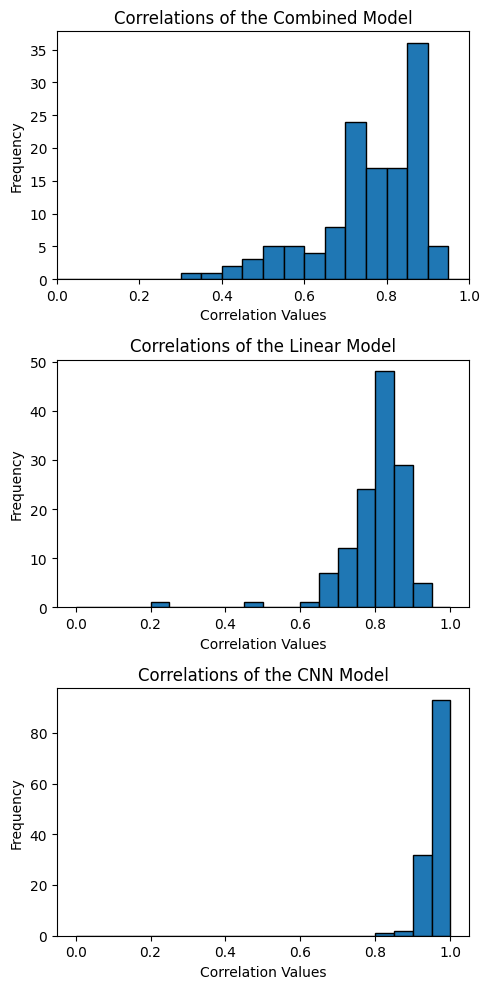



Combination Model Metrics: Mean:0.7606257130663244, SD:0.12624326648905054, Min:0.34803833318528904, Max:0.9239062991629435
Combination Linear Metrics: Mean:0.806533671739138, SD:0.08488676666212146, Min:0.2259681568999991, Max:0.9417522310753891
Combination CNN Metrics: Mean:0.9531219663860281, SD:0.016897073218624426, Min:0.8481877766706473, Max:0.9734135621481528


In [ ]:
# Let's compute the correlations on the test set predictions and plot them
from scipy.stats import pearsonr

# For the combined model
# Compute the Pearson correlation for each neuron
correlations = []
for neuron_idx in range(num_neurons):
    corr, _ = pearsonr(true_responses[:, neuron_idx], predicted_responses[:, neuron_idx])
    correlations.append(corr)
correlations = np.array(correlations)

# For the linear model
# Compute the Pearson correlation for each neuron
correlations_linear = []
for neuron_idx in range(num_neurons):
    corr, _ = pearsonr(true_responses_linear[:, neuron_idx], predicted_responses_linear[:, neuron_idx])
    correlations_linear.append(corr)
correlations_linear = np.array(correlations_linear)

# For the CNN model
# Compute the Pearson correlation for each neuron
correlations_CNN = []
for neuron_idx in range(num_neurons):
    corr, _ = pearsonr(true_responses_CNN[:, neuron_idx], predicted_responses_CNN[:, neuron_idx])
    correlations_CNN.append(corr)
correlations_CNN = np.array(correlations_CNN)


# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
# Define common bin edges
bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1

# Plot for the combined model
axs[0].hist(correlations, bins=bins, edgecolor='black')
axs[0].set_xlim(0, 1)
axs[0].set_xlabel('Correlation Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Correlations of the Combined Model')
mean_corr = np.mean(correlations)
std_corr = np.std(correlations)

# Plot for the linear model
axs[1].hist(correlations_linear, bins=bins, edgecolor='black')
axs[0].set_xlim(0, 1)
axs[1].set_xlabel('Correlation Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Correlations of the Linear Model')
mean_corr_linear = np.mean(correlations_linear)
std_corr_linear = np.std(correlations_linear)

# Plot for the CNN model
axs[2].hist(correlations_CNN, bins=bins, edgecolor='black')
axs[0].set_xlim(0, 1)
axs[2].set_xlabel('Correlation Values')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Correlations of the CNN Model')
mean_corr_CNN = np.mean(correlations_CNN)
std_corr_CNN = np.std(correlations_CNN)

# Adjust layout
plt.tight_layout()
plt.show()

# Print mean and standard deviation for the models
print()
print()
print(f'Combination Model Metrics: Mean:{mean_corr}, SD:{std_corr}, Min:{min(correlations)}, Max:{max(correlations)}')
print(f'Combination Linear Metrics: Mean:{mean_corr_linear}, SD:{std_corr_linear}, Min:{min(correlations_linear)}, Max:{max(correlations_linear)}')
print(f'Combination CNN Metrics: Mean:{mean_corr_CNN}, SD:{std_corr_CNN}, Min:{min(correlations_CNN)}, Max:{max(correlations_CNN)}')


### How did the models perform?

Comparing the performance of all three models, surprisingly the combined model showed the lowest performance with an average correlation of 0.76 for the test set predictions (SD = 0.13). Both the linear model (mean(r) = 0.8; SD = 0.09), the classic CNN model (mean(r) = 0.95; SD = 0.02) managed to outperform the combined model using a CNN with a readout layer. Not quite what I expected since it does not align with the findings of Klindt et al. (2017), but there could be multiple ways to tweak the model and improve its training. The regular CNN's performance is still quite impressive though! 

## Investigating Model Representations

Let's do some investigating of the model's internal representations to try and figure out whether our main model has learned to encode the spatial and feature dimensions correctly. We'll look at (1) the correlation between true and predicted response for every neuron, (2) see how the correlations relate to the labels and positions, and (3) see whether the readout weights allow predicting the labels. 

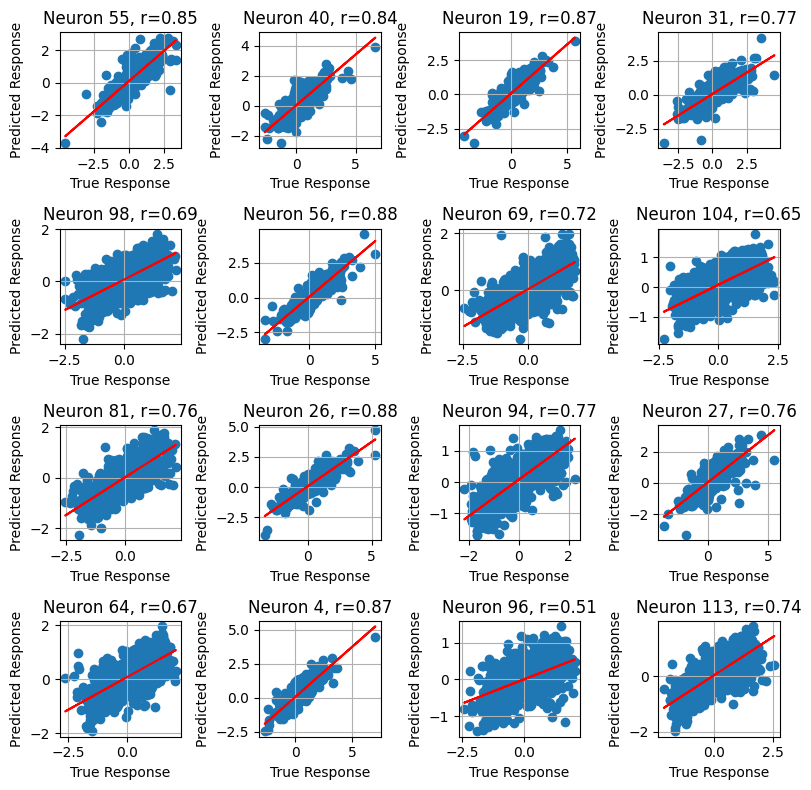

In [ ]:
# Plot true vs predicted responses for example neurons with correlation coefficients for the combination model

# Number of example neurons to plot
num_neurons_to_plot = 16
neuron_indices = np.random.choice(num_neurons, num_neurons_to_plot, replace=False)

plt.figure(figsize=(8, 8))
for i, neuron_idx in enumerate(neuron_indices):
    plt.subplot(4, 4, i + 1)
    plt.scatter(true_responses[:, neuron_idx], predicted_responses[:, neuron_idx])

    # Fit a linear model to get the correlation line
    p = np.polyfit(true_responses[:, neuron_idx], predicted_responses[:, neuron_idx], 1)
    plt.plot(true_responses[:, neuron_idx], np.poly1d(p)(true_responses[:, neuron_idx]), color='red')

    plt.xlabel('True Response')
    plt.ylabel('Predicted Response')
    plt.title(f'Neuron {neuron_idx}, r={correlations[neuron_idx]:.2f}')
    plt.grid(True)

plt.tight_layout()
plt.show()


<ipython-input-17-14325d41d03d>:60: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centers[:, 0], positions[:,0], c='blue', cmap='viridis')
<ipython-input-17-14325d41d03d>:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centers[:, 1], positions[:,1], c='red', cmap='viridis')
<ipython-input-17-14325d41d03d>:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(positions_norm[:, 0], positions_norm[:,1], c=[0.5, 0.5, 0.5], zorder=2)
<ipython-input-17-14325d41d03d>:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The k

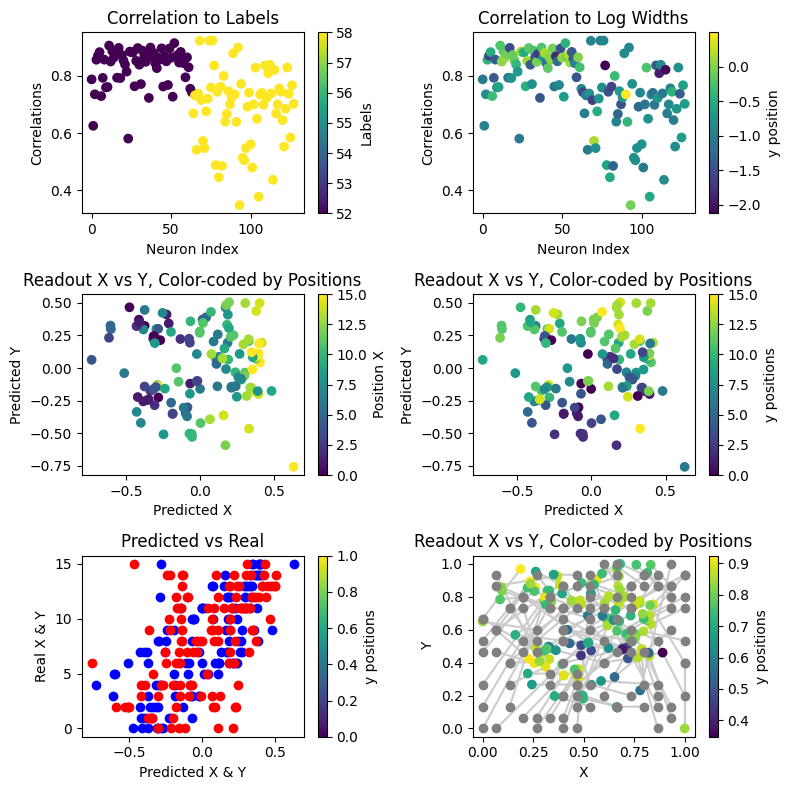


PearsonRResult(statistic=0.7028229511137951, pvalue=2.313539854584405e-20)
PearsonRResult(statistic=0.5485555712797525, pvalue=2.039730343642762e-11)


In [ ]:
# Analyze correlations with respect to labels and positions of the combined model

# Define the data
labels = data['labels']
positions = data['positions']

# For plotting the readout x vs readout y, color-coded by positions
centers = model.readout.centers.detach().cpu().numpy()
# Access the log widths from the readout layer
# They represent the logarithm of the widths of Gaussian kernels used to process the input features
log_widths = model.readout.log_widths.cpu().detach().numpy()
# Ensure log_widths and correlations have the same length
assert len(log_widths) == len(correlations), "The length of log_widths and correlations must match."

# normalize both center and position values
# Min-max normalization function
def min_max_normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val)
# Normalize positions and centers
positions_norm = min_max_normalize(positions)
centers_norm = min_max_normalize(centers)


# Plot the correlations
plt.figure(figsize=(8, 8))

plt.subplot(3, 2, 1)
plt.scatter(np.arange(num_neurons), correlations, c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Correlation to Labels')

plt.subplot(3, 2, 2)
plt.scatter(np.arange(num_neurons), correlations, c=log_widths, cmap='viridis')
plt.colorbar(label='y position')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Correlation to Log Widths')

plt.subplot(3, 2, 3)
sc = plt.scatter(centers[:, 0], centers[:, 1], c=positions[:, 0], cmap='viridis')
plt.colorbar(sc, label='Position X')
plt.xlabel('Predicted X')
plt.ylabel('Predicted Y')
plt.title('Readout X vs Y, Color-coded by Positions')

plt.subplot(3, 2, 4)
plt.scatter(centers[:, 0], centers[:, 1], c=positions[:, 1], cmap='viridis')
plt.colorbar(label='y positions')
plt.xlabel('Predicted X')
plt.ylabel('Predicted Y')
plt.title('Readout X vs Y, Color-coded by Positions')

plt.subplot(3, 2, 5)
plt.scatter(centers[:, 0], positions[:,0], c='blue', cmap='viridis')
plt.scatter(centers[:, 1], positions[:,1], c='red', cmap='viridis')
plt.colorbar(label='y positions')
plt.xlabel('Predicted X & Y')
plt.ylabel('Real X & Y')
plt.title('Predicted vs Real')

plt.subplot(3, 2, 6)
plt.scatter(positions_norm[:, 0], positions_norm[:,1], c=[0.5, 0.5, 0.5], zorder=2)
plt.scatter((centers_norm[:, 0]), (centers_norm[:,1]), c=correlations, cmap='viridis', zorder=1)
for n in range(1,128):
  plt.plot([positions_norm[n,0], (centers_norm[n,0])],[positions_norm[n,1], (centers_norm[n,1])],'k-', zorder=0, c=[0.8, 0.8, 0.8])

plt.colorbar(label='y positions')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Readout X vs Y, Color-coded by Positions')

plt.tight_layout()
plt.show()

print()
print(pearsonr(centers_norm[:, 0], positions_norm[:,0]))
print(pearsonr(centers_norm[:, 1], positions_norm[:,1]))

### Has the model built the right representations?

The combination model has clearly built representations that are able to differentiate between the two cell types. This can be seen in the two clusters that form when plotting the weights of the readout layer against one other. It seems that the model can learn a small number of cell types (2 in this case) from the neural data and then transform these features into a higher-dimensional output. However, whether the internal representations correctly code for the neuron’s receptive field location is a bit harder to interpret. We can observe a color gradient when plotting the position of the spatial location of the readout layer and coding it by receptive field position. But it is unclear how well that maps onto the change of position between the readout layer and the real positions.

We also computed the correlation between the original position axes and the readout layer position axes, and those both show significant correlations (r(x)=0.7; r(y)=0.5). 
Did the model representations change the representational space? Let's have a look...

<ipython-input-18-d16b2215cd7f>:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(positions_norm[:, 0], positions_norm[:,1], c=[0.5, 0.5, 0.5], zorder=2)
<ipython-input-18-d16b2215cd7f>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([positions_norm[n,0], (centers_norm[n,0])],[positions_norm[n,1], (centers_norm[n,1])],'k-', alpha=0.3, c=[0.8, 0.8, 0.8], zorder=0)


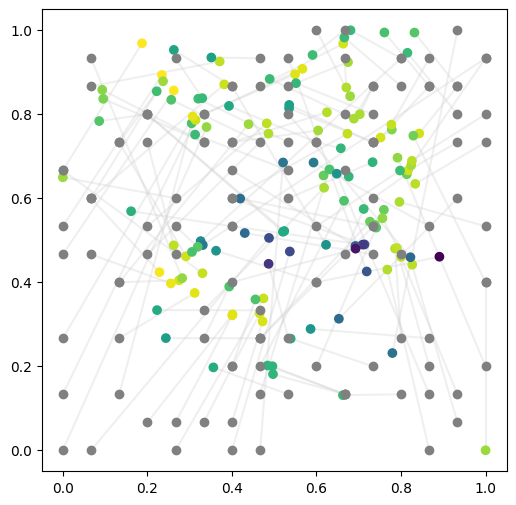

In [ ]:
# Did the model representations change the space?
# Coding for change of position between the readout layer and the real positions

plt.figure(figsize=(6, 6))
plt.scatter(positions_norm[:, 0], positions_norm[:,1], c=[0.5, 0.5, 0.5], zorder=2)
plt.scatter((centers_norm[:, 0]), (centers_norm[:,1]), c=correlations, cmap='viridis', zorder=1)
for n in range(1,128):
  plt.plot([positions_norm[n,0], (centers_norm[n,0])],[positions_norm[n,1], (centers_norm[n,1])],'k-', alpha=0.3, c=[0.8, 0.8, 0.8], zorder=0)



In [ ]:
# Did the space shrink?
# Compute the distance between each point change and see its directionality


# Compute distances and directions
distances = np.linalg.norm((centers_norm) - positions_norm, axis=1)
directions = (centers_norm) - positions_norm


# Calculate average distance in the original positions dataset
original_distances = np.linalg.norm(positions_norm[:, np.newaxis] - positions_norm[np.newaxis, :], axis=2)
average_original_distance = np.mean(original_distances[np.triu_indices_from(original_distances, k=1)])

# Calculate average distance in the new positions dataset
adjusted_positions = centers_norm
new_distances = np.linalg.norm(adjusted_positions[:, np.newaxis] - adjusted_positions[np.newaxis, :], axis=2)
average_new_distance = np.mean(new_distances[np.triu_indices_from(new_distances, k=1)])

# Compare the average distances
if average_new_distance < average_original_distance:
    change = "shrank"
else:
    change = "expanded"

print(f"Average distance of the positions: {average_original_distance:.2f}")
print(f"Average distance in the readout layer: {average_new_distance:.2f}")
print(f"The space has {change}.")
print()


# Is the difference between the spaces' packedness significant?
# Perform t-test
import numpy as np
from scipy.stats import ttest_ind

# Flatten the distance matrices to obtain pairwise distances
original_distances_flat = original_distances.flatten()
new_distances_flat = new_distances.flatten()

# Perform t-test
t_stat, p_value = ttest_ind(original_distances_flat, new_distances_flat)

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2e}")

if p_value < 0.05:
    result = "significant"
else:
    result = "not significant"

print(f"The difference in distances is {result}.")
print()


# Compute and effect size
# Calculate means and standard deviations
mean_original = np.mean(original_distances_flat)
mean_new = np.mean(new_distances_flat)
std_original = np.std(original_distances_flat)
std_new = np.std(new_distances_flat)

# Calculate Cohen's d
cohen_d = (mean_original - mean_new) / np.sqrt((std_original**2 + std_new**2) / 2)

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Cohen's d: {cohen_d:.2f}")

if p_value < 0.05:
    result = "significant"
else:
    result = "not significant"

print(f"The difference in distances is {result}.")

Average distance of the positions: 0.53
Average distance in the readout layer: 0.40
The space has shrank.

t-statistic: 54.25
p-value: 0.00e+00
The difference in distances is significant.

t-statistic: 54.25
p-value: 0.00e+00
Cohen's d: 0.60
The difference in distances is significant.


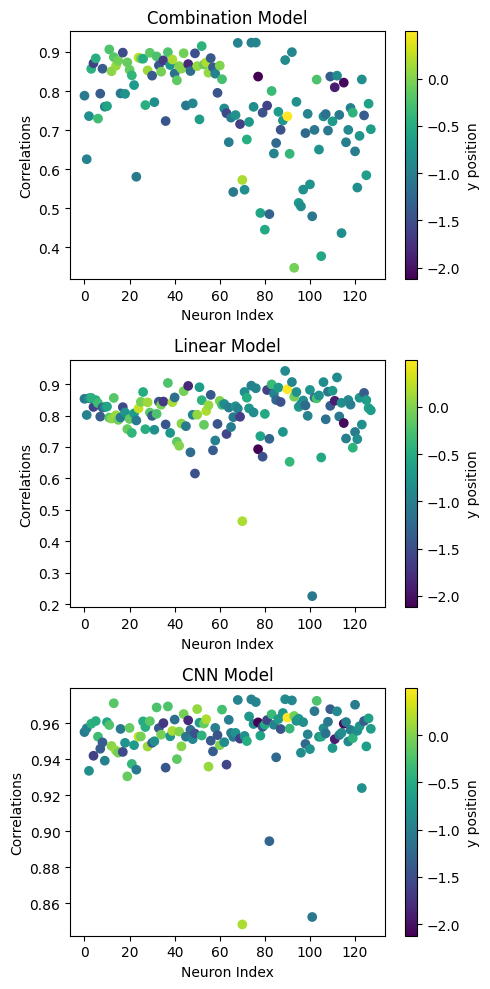

In [ ]:
# Comparing the feature dimension across models

# Plot the correlations
plt.figure(figsize=(5, 10))

plt.subplot(3, 1, 1)
plt.scatter(np.arange(num_neurons), correlations, c=log_widths, cmap='viridis')
plt.colorbar(label='y position')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Combination Model')

plt.subplot(3, 1, 2)
plt.scatter(np.arange(num_neurons), correlations_linear, c=log_widths, cmap='viridis')
plt.colorbar(label='y position')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Linear Model')

plt.subplot(3, 1, 3)
plt.scatter(np.arange(num_neurons), correlations_CNN, c=log_widths, cmap='viridis')
plt.colorbar(label='y position')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('CNN Model')

plt.tight_layout()
plt.show()

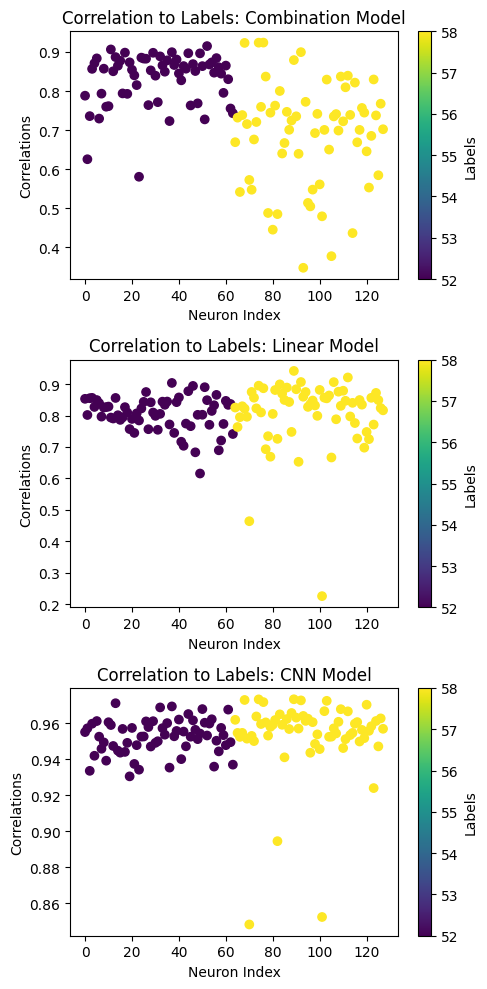

In [ ]:
# Analyze correlations with respect to labels and positions

# Comparison of the feature dimension across models

# Define the data
labels = data['labels']
positions = data['positions']

# Plot the correlations
plt.figure(figsize=(5, 10))

plt.subplot(3, 1, 1)
plt.scatter(np.arange(num_neurons), correlations, c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Correlation to Labels: Combination Model')

plt.subplot(3, 1, 2)
plt.scatter(np.arange(num_neurons), correlations_linear, c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Correlation to Labels: Linear Model')

plt.subplot(3, 1, 3)
plt.scatter(np.arange(num_neurons), correlations_CNN, c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('Neuron Index')
plt.ylabel('Correlations')
plt.title('Correlation to Labels: CNN Model')


plt.tight_layout()
plt.show()

### Did the representational space actually shrink? 

It does look like the position space of the readout layer is more compact than the original position space. And we can confirm this shrinkage of the space by visualizing the distance between the point changes and computing the average distance between the point in the original space (d(average)=0.53) and in the readout layer (d(average)=0.40). A two-sample t-test confirmed that there was a significant difference in the distances between the original (M = 0.53, SD = 0.26) and new datasets (M = 0.39, SD = 0.20); t(32766) = 54.25, p = 0.00e+00, d = 0.60.

Let's do one final test and see whether we can predict the labels from the readout weights.

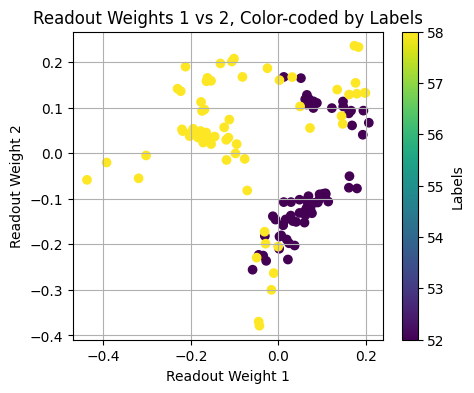

In [ ]:
# Study the readout weight – do they allow predicting the labels?

# Extract and plot the readout weights against each other, color-coded by labels
weights = model.readout.weights.detach().cpu().numpy()

plt.figure(figsize=(5, 4))
sc = plt.scatter(weights[:, 0], weights[:, 1], c=labels, cmap='viridis')
plt.colorbar(sc, label='Labels')
plt.xlabel('Readout Weight 1')
plt.ylabel('Readout Weight 2')
plt.title('Readout Weights 1 vs 2, Color-coded by Labels')
plt.grid(True)
plt.show()

### Do the read out weights allow predicting the labels?

Yes, based on the scatter plot color coded by labels, it looks like there is a pretty clear clustering that would allow for predicting the labels. Plotting the readout weights against each other further confirms this, although the clustering is not as clear as I had hoped it to be.